In [1]:
# Python Standard Library Packages
import os
import glob
import argparse
import copy

# Community Developed Packages
import numpy as np
import astropy.units as u
import astropy.constants as c
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

# HERA Collaboration Packages
import hera_pspec as hp
from pyuvdata import UVData

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument(
    '-F',
    '--files',
    help='Designate the hdf5 files to be concatenated in time.',
    nargs='*',
    required=True)
parser.add_argument(
    '-W',
    '--wedge',
    help='Turn wedge folding on',
    action='store_true')
parser.add_argument(
    '-C',
    '--cosmo',
    help='Apply cosmological units.',
    action='store_true')
parser.add_argument(
    '-S',
    '--savepath',
    help='Designate the path where the new hdf5 files will be saved. Default is path to data files.')

_StoreAction(option_strings=['-S', '--savepath'], dest='savepath', nargs=None, const=None, default=None, type=None, choices=None, help='Designate the path where the new hdf5 files will be saved. Default is path to data files.', metavar=None)

In [3]:
"""Uncomment this code when running as .py:"""
# args = parser.parse_args()
# dfiles = np.array(sorted(args.files))

'Uncomment this code when running as .py:'

In [4]:
"""Uncomment this code when running as .ipynb:"""
args = parser.parse_args(
    "-F /lustre/aoc/projects/hera/afortino/H1C_IDR2_1/OCRS/2458098/LSThrs_5.0_to_6.0/FREQrng_530_to_730/*.p?.HH.hdf5.*.UVP".split())

In [5]:
"""Formatting command line arguments:"""
dfiles = sorted(glob.glob(args.files[0]))
dfiles_basename = [os.path.basename(dfile) for dfile in dfiles]
wedge = args.wedge
cosmo = args.cosmo
if args.savepath is None:
    savepath = os.path.dirname(args.files[0])
else:
    savepath = args.savepath
print 'Saving files to:\n{}'.format(savepath)

Saving files to:
/lustre/aoc/projects/hera/afortino/H1C_IDR2_1/OCRS/2458098/LSThrs_5.0_to_6.0/FREQrng_530_to_730


In [6]:
"""Loading metadata:"""
# This will be deprecated once the UVPspec objects supports adding additional attributes
metadata = np.load(os.path.join(os.path.dirname(dfiles[0]), 'metadata.npz'))

FREQrng = metadata['FREQrng'].tolist()
antpos = metadata['antpos'].tolist()
blp_reds = metadata['blp_reds'].tolist()
blpairs = [(tuple(blpair[0]), tuple(blpair[1])) for blpair in metadata['blpairs'].tolist()]
bls_reds = metadata['bls_reds'].tolist()
baselines = metadata['baselines'].tolist()
norms = metadata['norms'].tolist()

LSTrng = metadata['uvd_extra_keywords'].tolist()['LSTrng'].tolist()
JD = metadata['uvd_extra_keywords'].tolist()['JD']
JDt0 = metadata['uvd_extra_keywords'].tolist()['JDt0']
JDtf = metadata['uvd_extra_keywords'].tolist()['JDtf']
numfiles = metadata['uvd_extra_keywords'].tolist()['numfiles']
ext = metadata['uvd_extra_keywords'].tolist()['ext']
xants = metadata['uvd_extra_keywords'].tolist()['xants'].tolist()

In [7]:
"""Creating dictionary for converting between pol integers and pol strings:"""
pol_int_to_str = {1: 'pI', 2: 'pQ', 3: 'pU', 4: 'pV', -5: 'XX', -6: 'YY', -7: 'XY', -8: 'YX'}

/lustre/aoc/projects/hera/afortino/anaconda3/envs/hera/lib/python2.7/site-packages/ipykernel_launcher.py:51: ComplexWarning: Casting complex values to real discards the imaginary part


/lustre/aoc/projects/hera/afortino/H1C_IDR2_1/OCRS/2458098/LSThrs_5.0_to_6.0/FREQrng_530_to_730/zen.2458098.42378_46852.pI_pQ_pU_pV.HH.2D_p_cos.OCRS.pdf


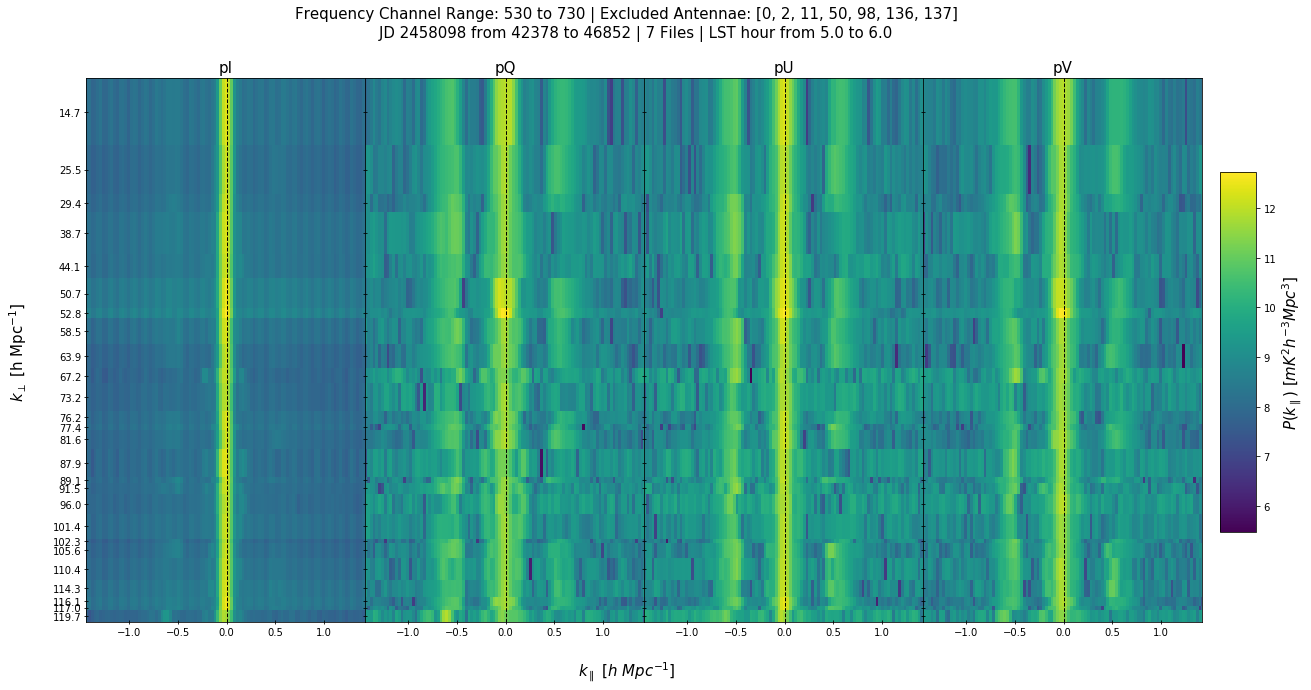

In [8]:
"""Making plots:"""
# Determine how many rows and columns are needed
if (len(dfiles) <= 4) or (len(dfiles) > 8):
    ncols = len(dfiles)
    nrows = 1
else:
    ncols = 4
    nrows = 2
# Initialize the axes objects
f, axes = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    sharex=True,
    sharey=True,
    squeeze=False,
    figsize=(20, 10))

# Plot each file
pols = []
plt.subplots_adjust(wspace=0, hspace=0.1)
for dfile, ax in zip(dfiles, axes.flatten()):
    """Load in UVPspec objects and average the spectra along redundant baseline groups and time"""
    uvp = hp.UVPSpec()
    uvp.read_hdf5(dfile)
    uvp.average_spectra(blpair_groups=blp_reds.values(), time_avg=True)
    
    """Grab polarization string for naming the plot later on:"""
    pol = pol_int_to_str[uvp.pol_array[0]]
    pols.append(pol)

    """Format data array"""
    data = uvp.data_array[0][:, :, 0]
    if wedge:
        uvp.fold_spectra()
        data = uvp.data_array[0][:, data.shape[1] // 2:, 0]

    """Format k_para axis:"""
    x_axis = (uvp.get_dlys(0)*1e9).tolist()
    if cosmo:
        x_axis = uvp.get_kparas(0).tolist()
    if wedge:
        x_axis.insert(0, 0)
    ax.set_xlim((x_axis[0] / 2, x_axis[-1] / 2))
    
    """Format k_perp axis:"""
    # Calculate kpr indices, and stretch wedgeslices array by a factor of 10
    norm_indices = [int(norm * 10) for norm in norms]
    data_stretch = np.zeros((norm_indices[-1], data.shape[-1]), dtype=np.float64)
    j = 0
    for i in range(len(norm_indices)):
        data_stretch[j:norm_indices[i]] = data[i]
        j = norm_indices[i]

    # Find kpr mid-indicies for the tickmarks
    norm_midindices = []
    for i in range(len(norm_indices)):
        if i == 0:
            norm_midindices.append(norm_indices[i] / 2.)
        else:
            norm_midindices.append((norm_indices[i] + norm_indices[i - 1]) / 2.)
    data = data_stretch[...]
    
    # Setting ticks and labels
    ax.set_yticks(norm_midindices)
    ax.set_yticklabels(norms, fontsize=10)
        
    """Plotting"""
    # Data
    im = ax.imshow(
        np.log10(np.abs(data)),
        aspect='auto',
        interpolation='nearest',
        extent=[x_axis[0], x_axis[-1], norm_indices[-1], 0])
    
    # Horizon lines
    horizons = [(norm*u.m/c.c).to(u.ns).value for norm in norms]
    j = 0
    for i, (horizon, norm) in enumerate(zip(horizons, norms)):
        x1, y1 = [horizon, horizon], [j, norm_indices[i]]
        x2, y2 = [-horizon, -horizon], [j, norm_indices[i]]
        ax.plot(x1, y1, x2, y2, color='#ffffff', linestyle='--', linewidth=1)
        j = norm_indices[i]
    
    # Line at k_para = 0
    ax.axvline(x=0, color='#000000', ls='--', lw=1)
    
    ax.tick_params(axis='both', direction='inout')
    
    ax.set_title(pol, fontsize=15)
cbar_ax = f.add_axes([0.9125, 0.25, 0.025, 0.5])
cbar = f.colorbar(im, cax=cbar_ax)

if cosmo:
    f.text(0.5, 0.05, r'$k_{\parallel}\ [h\ Mpc^{-1}]$', fontsize=15, ha='center')            
    f.text(0.07, 0.5, r'$k_{\perp}\ [\rm h\ Mpc^{-1}]$', fontsize=15, va='center', rotation='vertical')
else:
    f.text(0.5, 0.05, r'$\tau\ [ns]$', fontsize=15, ha='center')
    f.text(0.07, 0.5, r'Baseline Group $[m]$', fontsize=15, va='center', rotation='vertical')
    
if ('C' in ext) or ('K' in ext):
    cbar.set_label(r"$P(k_{\parallel})\ [mK^2h^{-3}Mpc^3]$", fontsize=15, ha='center')
else:
    cbar.set_label(r'$P(\tau)\ [mK^2]$', fontsize=15, ha='center')
    

f.suptitle('Frequency Channel Range: {} to {} | Excluded Antennae: {}\n\
    JD {} from {} to {} | {} Files | LST hour from {} to {}'.format(
    FREQrng[0],
    FREQrng[1],
    str(xants),
    JD,
    JDt0,
    JDtf,
    numfiles,
    LSTrng[0],
    LSTrng[1]), fontsize=15)

pols = '_'.join(pols)
if wedge:
    tag_wedge = '2D_w'
else:
    tag_wedge = '2D_p'

if cosmo:
    tag_unit = 'cos'
else:
    tag_unit = 'std'

# plt.savefig(os.path.join(savepath, 'zen.{JD}.{JDt0}_{JDtf}.{pols}.HH.{tagw}_{tagu}.{ext}.pdf'.format(
#     JD=JD,
#     JDt0=JDt0,
#     JDtf=JDtf,
#     pols=pols,
#     tagw=tag_wedge,
#     tagu=tag_unit,
#     ext=ext)))

print os.path.join(savepath, 'zen.{JD}.{JDt0}_{JDtf}.{pols}.HH.{tagw}_{tagu}.{ext}.pdf'.format(
    JD=JD,
    JDt0=JDt0,
    JDtf=JDtf,
    pols=pols,
    tagw=tag_wedge,
    tagu=tag_unit,
    ext=ext))